In [1]:
# libraries
import numpy as np
import pandas as pd
from sklearn.decomposition import TruncatedSVD
from scipy.sparse.linalg import svds

import matplotlib.pyplot as plt
import seaborn as sns

from baseline import Baseline, UniformRandomBaseline, GlobalMeanBaseline, MeanOfMeansBaseline

plt.style.use('seaborn-darkgrid')

In [123]:
data = pd.read_csv('../data/movie.data', sep='\t', names=["userid", "itemid", "rating", "timestamp"])

movie_columns  = ['movie id', 'movie title', 'release date', 'video release date', 'IMDb URL',
                  'unknown','Action','Adventure', 'Animation',"Children's", 'Comedy', 'Crime',
                  'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery',
                  'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

movies = pd.read_csv('../data/u.item', sep='|', names=movie_columns , encoding='latin-1',index_col="movie id",parse_dates=['release date'])
ratings = data.rating # 영화 ratings

## EDA

In [79]:
# 특정영화에 대한 개별 평점 정보 (1~5)
data.head()

,userid,itemid,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [80]:
print('Number of data is ', data.shape[0])
print('Number of unique users are ',data.userid.nunique())
print('avg number of movies per user is ', round(data.shape[0]/data.userid.nunique(),2))

Number of data is  100000
Number of unique users are  943
avg number of movies per user is  106.04


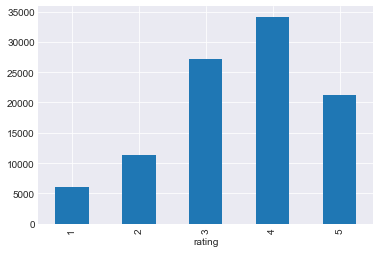

In [81]:
# 평점 분포.
data.groupby('rating').size().plot(kind='bar')

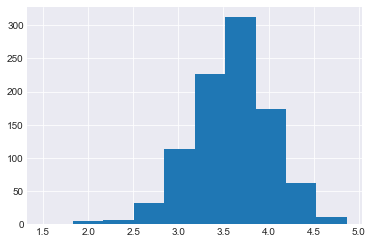

In [82]:
# user별 평균 평점 histogram
data.groupby('userid').rating.mean().hist()

In [83]:
# 영화의 평균평점
movie_means = data.join(movies['movie title'], on='itemid').groupby('movie title')['rating'].mean()

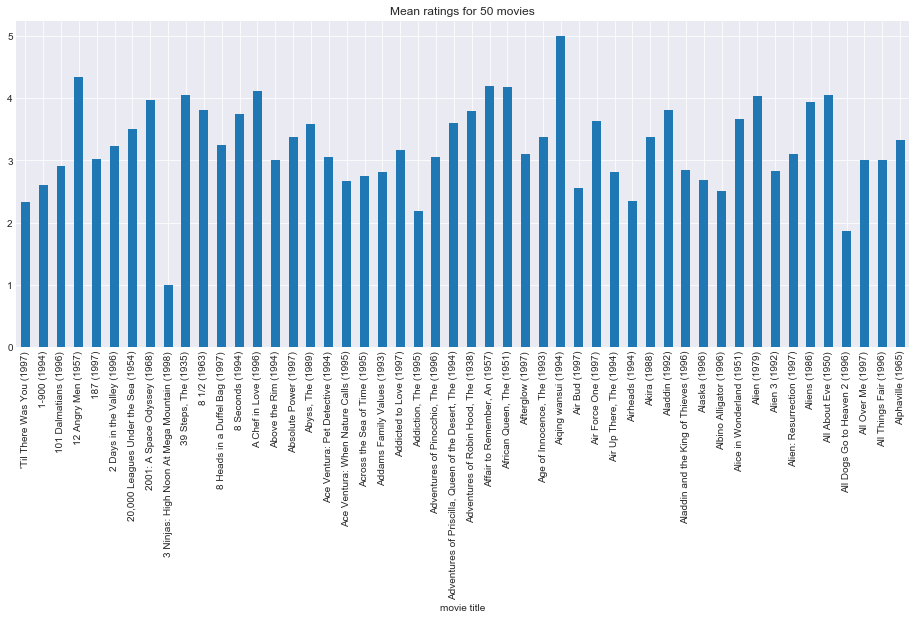

In [84]:
movie_means[:50].plot(kind='bar',figsize=(16,6), title='Mean ratings for 50 movies')

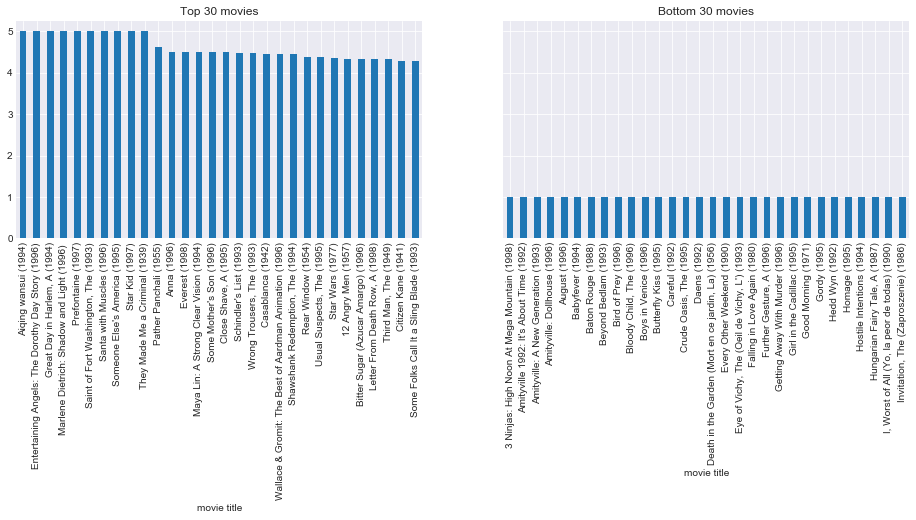

In [85]:
fig,ax = plt.subplots(1,2, figsize=(16,4), sharey=True)
movie_means.nlargest(30).plot(kind='bar', ax=ax[0], title='Top 30 movies')
movie_means.nsmallest(30).plot(kind='bar', ax=ax[1], title='Bottom 30 movies')

(0, 943)

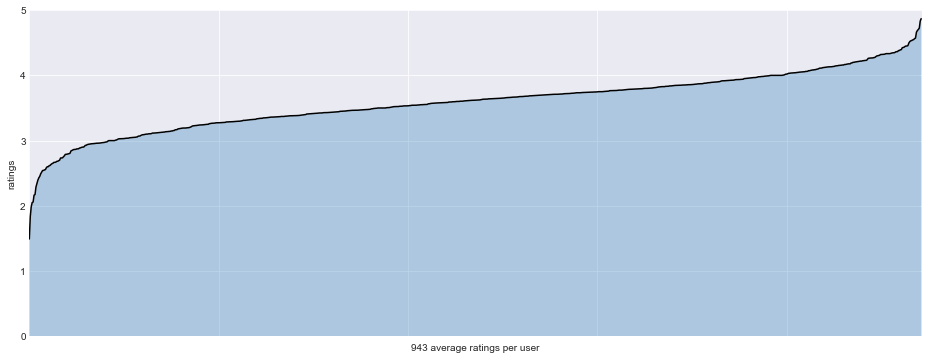

In [86]:
# 유저 평균
user_means = data.groupby('userid').rating.mean().sort_values()
_, ax = plt.subplots(figsize=(16,6))
ax.plot(range(len(user_means)), user_means.values, 'k-')

ax.fill_between(range(len(user_means)), user_means.values, alpha=0.3)
ax.set_xticklabels([])
ax.set_ylabel('ratings')
ax.set_xlabel(f'{len(user_means)} average ratings per user')
ax.set_ylim(0,5)
ax.set_xlim(0, len(user_means))

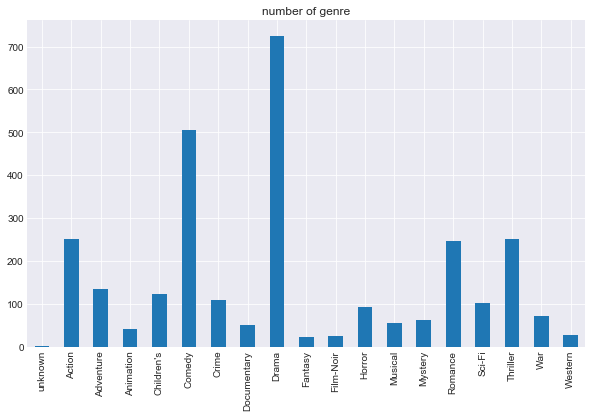

In [87]:
movies.iloc[:,4:].sum().plot(kind='bar', title='number of genre', figsize=(10,6))

## MF

In [127]:
user_base = data.pivot_table('rating', index='userid',columns='itemid')
movie_base = data.pivot_table('rating', index='itemid',columns='userid')

R = movie_base.values

In [40]:
def interpolate(R, method=True):
    """
    결측치 보간함수.
    """
    if method ==True:
        for i in range(len(R)):
            nan_mask = np.isnan(R[i,:])
            mean = R[i,~nan_mask].mean()
            R[i, nan_mask] = mean
    
    else :
        nan_mask = np.isnan(R)
        R[nan_mask] = 0
    return R

### SVD

In [22]:
SVD = TruncatedSVD(n_components= 10) # 몇개의 component로 압축해야하나.

# user_mat = SVD.fit_transform(user_base)
movie_mat = SVD.fit_transform(R)

In [23]:
np.dot(movie_mat , SVD.components_)

array([[ 4.24632302e+00,  1.84189464e+00, -1.12161102e-01, ...,
         2.01430174e+00,  1.38469518e+00,  1.75332141e+00],
       [ 2.03948476e+00, -7.34905176e-02, -1.70371711e-02, ...,
        -1.34087888e-02,  1.35307865e-01,  2.09176497e+00],
       [ 1.27886228e+00,  1.72681488e-01,  9.14371603e-02, ...,
         3.03722243e-01, -4.36473346e-01,  1.01844281e+00],
       ...,
       [-8.24086139e-03,  1.05763351e-02,  1.96420381e-02, ...,
        -8.25530483e-04,  1.43707293e-02, -9.42781151e-03],
       [ 1.96210923e-02,  1.04822326e-03, -3.19792207e-03, ...,
        -3.55053268e-03,  2.51485130e-03,  2.70020366e-02],
       [ 5.79589291e-02, -9.33644001e-04, -1.02387192e-02, ...,
        -4.64777641e-03, -2.98313693e-02,  2.67791388e-02]])

In [24]:
movie_mat

array([[ 6.14693964e+01,  2.13594698e+01, -3.69768765e+00, ...,
        -2.76937135e+00,  6.43772179e+00, -1.10292092e-01],
       [ 2.25371805e+01,  1.72000051e+00, -1.36162850e+01, ...,
        -2.00042386e+00, -7.94800539e+00, -4.82940251e+00],
       [ 1.27670668e+01,  7.00674981e+00, -2.53584117e+00, ...,
        -2.45613086e+00,  2.70230411e+00, -3.19540988e+00],
       ...,
       [ 1.94590615e-02,  1.09719741e-01,  1.16117637e-01, ...,
         5.80350994e-03,  4.24150350e-02, -8.79329531e-03],
       [ 2.12085550e-01, -2.57657706e-02, -9.89756626e-02, ...,
         4.65731614e-02, -1.82766158e-01, -2.14006920e-02],
       [ 2.02986653e-01, -4.97382598e-02, -5.69481388e-02, ...,
         1.27299280e-01, -1.65635238e-01,  1.55448365e-01]])

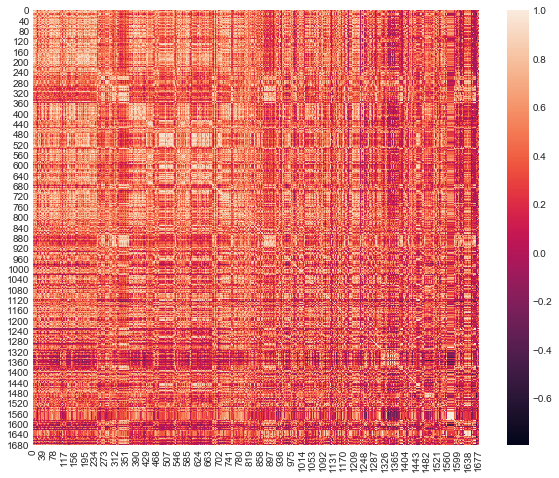

In [25]:
# correlation and heatmap
# user_corr = np.corrcoef(user_mat) 
movie_corr = np.corrcoef(movie_mat) 

# fig, ax = plt.subplots(1,2,figsize=(15,8))
# sns.heatmap(user_corr, ax=ax[0])
# sns.heatmap(movie_corr, ax=ax[1])

plt.figure(figsize=(10,8))
sns.heatmap(movie_corr)

In [26]:
movie_title = list(movies['movie title'])
ind_movie = movie_title.index('GoldenEye (1995)')

In [27]:
test_list = np.array(movie_title)[movie_corr[ind_movie]>=0.9][:50]
test_list

array(['GoldenEye (1995)', 'Braveheart (1995)', 'Bad Boys (1995)',
       'Batman Forever (1995)', 'Crimson Tide (1995)', 'Desperado (1995)',
       'Net, The (1995)', 'Stargate (1994)', 'Crow, The (1994)',
       'Maverick (1994)', 'Fugitive, The (1993)', 'Jurassic Park (1993)',
       'Aladdin (1992)', 'Terminator 2: Judgment Day (1991)',
       'Die Hard (1988)', 'Top Gun (1986)',
       'Empire Strikes Back, The (1980)', 'Return of the Jedi (1983)',
       'Terminator, The (1984)', 'Groundhog Day (1993)',
       'Indiana Jones and the Last Crusade (1989)', 'Die Hard 2 (1990)',
       'Star Trek VI: The Undiscovered Country (1991)',
       'Star Trek: The Wrath of Khan (1982)',
       'Star Trek III: The Search for Spock (1984)',
       'Star Trek IV: The Voyage Home (1986)', 'Batman Returns (1992)',
       'Young Guns (1988)', 'Under Siege (1992)', 'Sneakers (1992)',
       'Hunt for Red October, The (1990)', 'Judge Dredd (1995)',
       'True Lies (1994)', 'Last Action Hero (1993)

In [93]:
def split_train_test(data, percent_test=0.1):
    """Split the data into train/test sets.
    :param int percent_test: Percentage of data to use for testing. Default 10.
    """
    n, m = data.shape             # # users, # movies
    N = n * m                     # # cells in matrix

    # Prepare train/test ndarrays.
    train = data.copy()
    test = np.ones(data.shape) * np.nan

    # Draw random sample of training data to use for testing.
    tosample = np.where(~np.isnan(train))       # ignore nan values in data
    idx_pairs = list(zip(tosample[0], tosample[1]))   # tuples of row/col index pairs

    test_size = int(len(idx_pairs) * percent_test)  # use 10% of data as test set
    train_size = len(idx_pairs) - test_size   # and remainder for training

    indices = np.arange(len(idx_pairs))         # indices of index pairs
    sample = np.random.choice(indices, replace=False, size=test_size)

    # Transfer random sample from train set to test set.
    for idx in sample:
        idx_pair = idx_pairs[idx]
        test[idx_pair] = train[idx_pair]  # transfer to test set
        train[idx_pair] = np.nan          # remove from train set

    # Verify everything worked properly
    assert(train_size == N-np.isnan(train).sum())
    assert(test_size == N-np.isnan(test).sum())

    # Return train set and test set
    return train, test

In [110]:
baselines = {}
baselines['gm'] = GlobalMeanBaseline
baselines['ur'] = UniformRandomBaseline
baselines['mom'] = MeanOfMeansBaseline

In [28]:
class MF():
    """
    R : data matrix
    k : number of latent dimension
    learning _rate :
    reg_param : 
    epochs: 
    """
    def __init__(self, R, k, learning_rate, reg_param, epochs, verbose=False):
        self.R = R
        self.num_users, self.num_items = R.shape
        self.k = k
        self.reg_param = reg_param
        self.epochs = epochs
        self.verbose = verbose
        self.learning_rate = learning_rate
        
    def fit(self):
        self.P = np.random.normal(size=(self.num_users, self.k))
        self.Q = np.random.normal(size=(self.num_items, self.k))
        
        self.b_P = np.zeros(self.num_users)
        self.b_Q = np.zeros(self.num_items)
        self.b = np.mean(self.R[np.where(self.R != 0)])
        
        self.training_process = []
        for epoch in range(self.epochs):
            
            for i in range(self.num_users):
                for j in range(self.num_items):
                    if self.R[i,j] > 0:
                        self.gradient_descent(i,j, self.R[i,j])
            cost = self.cost()
            self.training_process.append((epoch, cost))
            
            if self.verbose == True and ((epoch + 1)) % 10 ==0 :
                print('iteration : %d ; cost = %.4f' % (epoch + 1, cost))
        
    
    def cost(self):
        xi, yi = self.R.nonzero()
        predicted = self.get_complete_matrix()
        cost = 0
        for x, y in zip(xi, yi):
            cost += pow(self.R[x, y] - predicted[x, y], 2)
        return np.sqrt(cost) / len(xi)

    def gradient(self, error,i,j):
        dp = (error * self.Q[j,:]) - (self.reg_param * self.P[i,:])
        dq = (error * self.P[i,:]) - (self.reg_param * self.Q[j,:])
        return dp, dq
        
    def gradient_descent(self, i, j, rating):
        prediction = self.get_prediction(i, j)
        error = rating - prediction
        
        self.b_P[i] += self.learning_rate * (error - self.reg_param*self.b_P[i])
        self.b_Q[j] += self.learning_rate * (error - self.reg_param*self.b_Q[j])
        
        dp, dq = self.gradient(error, i, j)
        self.P[i, :] += self.learning_rate * dp
        self.Q[j, :] += self.learning_rate * dq
        
    def get_prediction(self, i, j):
        return self.b + self.b_P[i] + self.b_Q[j] + self.P[i,:].dot(self.Q[j,:].T)
    
    def get_complete_matrix(self):
        return self.b + self.b_P[:, np.newaxis] + self.b_Q[np.newaxis:,] + self.P.dot(self.Q.T)
        
    def print_results(self):
        """
        print fit results
        """
        print("User Latent P:")
        print(self.P)
        print("Item Latent Q:")
        print(self.Q.T)
        print("P x Q:")
        print(self.P.dot(self.Q.T))
        print("bias:")
        print(self.b)
        print("User Latent bias:")
        print(self.b_P)
        print("Item Latent bias:")
        print(self.b_Q)
        print("Final R matrix:")
        print(self.get_complete_matrix())
        print("Final RMSE:")
        print(self.training_process[self.epochs-1][1])

In [284]:
# 시간복잡도 너무 큼

class MF():
    
    def __init__(self, r, k, learning_rate, reg_lambda, epochs, verbose=True):
        
        self.r = r
        self.num_users, self.num_items = r.shape
        self.k = k
        self.lr = learning_rate
        self.reg_lambda = reg_lambda
        self.epochs = epochs
        self.verbose = verbose
        
    
    def fit(self):
        self.p = np.random.random(size=(self.num_users, self.k))
        self.q = np.random.random(size=(self.num_items, self.k))
        
        self.process = []
        
        for epoch in range(self.epochs):
            
            for i in range(self.num_users):
                for j in range(self.num_items):
                     self.sgd(i,j, self.r[i,j])
            
            cost = self.cost()
            self.process.append((epoch, cost))
            
            if self.verbose == True and ((epoch + 1)) % 10 ==0 :
                print('iteration : %d ; cost = %.4f' % (epoch + 1, cost))
        
                    
                    
                    
    def sgd(self,i, j, r):
        
        error = r - self.p[i,:].dot(self.q[j,:].T)
        
        self.q[j,:] = self.q[j] + self.lr*(error*self.p[i,:] - self.reg_lambda*self.q[j,:])
        self.p[i,:] = self.p[i] + self.lr*(error*self.q[j,:] - self.reg_lambda*self.p[i,:])
        
    
    def cost(self):
        
        xi,yi = self.r.nonzero()
        pred = self.p.dot(self.q.T)
        cost = 0
        for i,j in zip(xi,yi):
            cost += (self.r[i,j] - pred[i,j])**2
            
        return cost/len(xi)
        
    
        

In [285]:
factorizer = MF(R, k=3, learning_rate=0.01, reg_lambda=0.01, epochs=10, verbose=True)
factorizer.fit()

iteration : 10 ; cost = nan


In [258]:
num_u , num_i = R.shape
p = np.random.random(size=(num_u, 10))
q = np.random.random(size=(num_i, 10))

In [281]:
error = R[0,0] - p[0,:].dot(q[0,:].T)

a = q[0] + 0.1*(error*p[0,:] - q[0,:])

R[i,j] - a[i,j]**2

[0.0165761  0.43580562 0.08980629 0.41797104 0.10699773 0.38335424
 0.8674465  0.54060053 0.1482875  0.15317398]
[0.16017126 0.63351725 0.33559104 0.46082249 0.27156045 0.55727309
 1.01383455 0.58841993 0.41771615 0.38266879]


In [221]:
train, test = split_train_test(R)

In [224]:
for i in range(len(train)):
    nan_mask = np.isnan(train[i,:])
    glob_mask = np.isnan(train)
    
    mean = train[i,~nan_mask].mean()
    global_mean = train[~glob_mask].mean()
    
    if np.isnan(train[i,:]).mean() != 1:
        train[i, nan_mask] = mean
    else :
        train[i, nan_mask] = global_mean


U, sigma, Vt = svds(train, k = 30)
sigma = np.diag(sigma)

all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + train.mean(axis=1).reshape(-1,1)
preds_df = round(pd.DataFrame(all_user_predicted_ratings), 2)

C:\Users\dhdcj\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice.
  """
C:\Users\dhdcj\AppData\Roaming\Python\Python37\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [226]:
pred = np.where(preds_df<1,1,np.where(preds_df>5,5,preds_df))

In [181]:
def rmse(pred_data, test_data):
    """Calculate root mean squared error for predictions on test data."""
    I = ~np.isnan(test_data)   # indicator for missing values
    N = I.sum()                # number of non-missing values
    sqerror = abs(test_data - pred_data) ** 2  # squared error array
    mse = sqerror[I].sum() / N                 # mean squared error
    return np.sqrt(mse)      

In [227]:
rmse(pred, test)

1.8253693735789478

## refrence
https://lsjsj92.tistory.com/569
https://towardsdatascience.com/beginners-guide-to-creating-an-svd-recommender-system-1fd7326d1f65

In [ ]:
num_users = 1000
num_items = 100
k = 10

P = np.random.normal(size=(num_users, k))
Q = np.random.normal(size=(num_items, k))

# self.b_P = np.zeros(self.num_users)
# self.b_Q = np.zeros(self.num_items)
# self.b = np.mean(self.R[np.where(self.R != 0)])

# self.training_process = []
# for epoch in range(self.epochs):

#     for i in range(self.num_users):
#         for j in range(self.num_items):
#             if self.R[i,j] > 0:
#                 self.gradient_descent(i,j, self.R[i,j])
#     cost = self.cost()
#     self.training_process.append((epoch, cost))
